# Consistency check 

### Import functions and stuff from pydd

In [168]:
import numpy as np
import scipy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.interpolate import interp1d

from pydd.analysis import get_match_pads
from pydd.binary import get_m_1, get_f_isco, get_m_2

import pickle
from typing import Tuple

import dynesty
from dynesty import plotting as dyplot

from tqdm.auto import trange
import corner
from scipy.interpolate import griddata
from scipy.stats import scoreatpercentile

In [169]:
from pydd.analysis import calculate_SNR, calculate_match_unnormd_fft, get_match_pads, loglikelihood_fft, loglikelihood_fft_data, calculate_match_unnormd_fft_data
from pydd.binary import (
    AccretionDisk,
    MSUN,
    PC,
    Phi_to_c,
    get_c_f,
    get_m_2, 
    _Phi_to_c_indef,
    VacuumBinary,
    convert,
    get_M_chirp,
    get_f_isco,
    get_r_isco,
    get_f_range,
    get_m_1,
    make_vacuum_binary,
    t_to_c,
    YR,
    amp,
    d2Phi_dt2,
    G,
    C,
    Psi,
    restricted_hypgeom,
    h_0,
    _Phi_to_c_indef
)

### Import stuff and functions from my library

In [170]:
import environments_handy_functions

# Reload libraries (in case you change something)
import importlib
importlib.reload(environments_handy_functions)

from environments_handy_functions import (
    df_dt,  
    find_grid, 
    time_to_coal_cumul, 
    time_to_coal,
    phase_f_cumul, 
    f_1yr, 
    h_0, 
    phase_f, 
    mycalculate_SNR, 
    amplitude, 
    Psi,
    myVacuumBinary, myAccretionDisk, myDarkMatter, myCombination)

In [171]:
plt.rcParams['agg.path.chunksize'] = 1000  # Set a larger value for chunksize
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["TimesNewRoman"]})
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["axes.labelsize"] = "12"

In [172]:
# constants

G = 6.67408e-11  # m^3 s^-2 kg^-1
C = 299792458.0  # m/s
MSUN = 1.98855e30  # kg
PC = 3.08567758149137e16  # m
YR = 365.25 * 24 * 3600  # s

### Select noise pattern

In [152]:
# Set detector
detector = "LISA"

In [153]:
# Set PSDs, choose observation time and SNR threshold (will set distance in signal system below)
if detector == "et":
    from pydd.noise import S_n_et as S_n, f_range_et as f_range_n  # ET

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Einstein Telescope"
elif detector == "ce":
    from pydd.noise import S_n_ce as S_n, f_range_ce as f_range_n  # CE

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Cosmic Explorer"
elif detector == "aLIGO":
    from pydd.noise import S_n_aLIGO as S_n, f_range_aLIGO as f_range_n  # aLIGO

    T_OBS = 1 * YR 
    SNR_THRESH = 12.0
    TITLE = "aLIGO"
elif detector == "LISA":
    from pydd.noise import S_n_LISA as S_n, f_range_LISA as f_range_n  # LISA

    T_OBS = 1 * YR #seconds
    SNR_THRESH = 100.0
    TITLE = "LISA"

# General Results

In [154]:
m1 = 1e5 * MSUN # kg
m2 = 10 * MSUN # kg
r_s = 2 * G * Mtot/ C**2 # Schwartzschild radius of m1
r0 = 3 * r_s
Mach = 100 
sigma0 = 1.5e10 / Mach**2
alpha = -1/2
Mtot = m1 + m2
q = m2/m1
M_chirp = m1**(3/5) * m2**(3/5) / Mtot**(1/5)

In [173]:
# Create accretion disk env 

AD_mine = myAccretionDisk(m1 = m1, 
                          m2 = m2, 
                          dist = 1., # for now
                          mach = Mach, 
                          sigma0 = sigma0, 
                          alpha = alpha, 
                          r0 = r0, 
                          chirp_mass = M_chirp
)

# find f_isco

r_isco = 6 * G * Mtot / C**2
f_isco = AD_mine.Binary_init.frequency(r_isco)

# Create accretion disk env (pydd)

AD_pydd = AccretionDisk(0, #PN
        sigma0 * Mach**2, #SigM2
        -1, #inout
        M_chirp, 
        q,
        0., # Phi_c
        0., # Tt_c
        1., # for now (dist)
        f_isco,
    )

In [156]:
# Define a grid of values to test 

freqs = np.linspace(1e-3, f_isco, 1000000)
radii = AD_mine.Binary_init.radius(freqs)

print('f_min:', freqs[0], ', f_max (ISCO):', freqs[-1])
print('r_max:', radii[0], ', r_min (ISCO):', radii[-1])

f_min: 0.001 , f_max (ISCO): 0.04396570178526473
r_max: 11038003694.913773 , r_min (ISCO): 886096855.2192434


# Time to coalescence: 

The time to coalescence for a given binary can be evaluated from the following formula:

$$t_c = \int_{f}^{f_{\mathrm{isco}}} \frac{dt}{df} df = \int_{r}^{r_{\mathrm{isco}}} \frac{dt}{dr} dr$$

In this notebook I will check the consistency between my version (numerical integration) and the one provided by pydd (analytical). I will also use my solution by-hand to independently check the analytical solution using the second expression for the time to coalescence and overplot the solutions to see which best matches.

In [157]:
def time_analytical(radii): 
    
    term1 = 128 * G**3 * m1 * m2**2 * Mtot 
    term2 = 5 * C**5 * np.sqrt(r0) * sigma0 * np.sqrt(G * Mtot) * q**2 * Mach**2 * radii**4
    
    numerator = - m2 * np.log(term1 + term2)
    denominator = 2 * np.sqrt(r0) * sigma0 * np.sqrt(G * Mtot) * q**2 * Mach**2
    
    return numerator/denominator

In [143]:
# my version of coalescence analytical

my_time_to_coal_ANALYTICAL = -(time_analytical(radii) - time_analytical(r_isco)) # negative otherwise

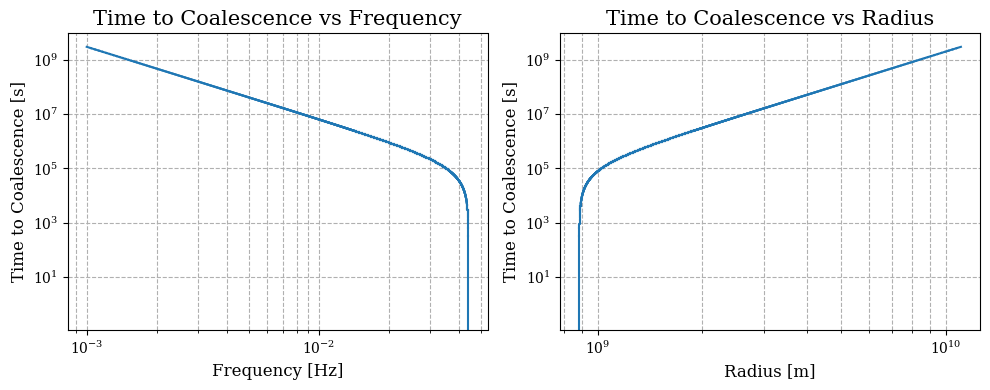

In [144]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Time to coalescence vs Frequency
ax1.loglog(freqs, my_time_to_coal_ANALYTICAL)
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Time to Coalescence [s]')
ax1.set_title('Time to Coalescence vs Frequency', fontsize=15)
ax1.grid(True, which="both", ls="--")

# Plot 2: Time to coalescence vs Radius
ax2.loglog(radii, my_time_to_coal_ANALYTICAL)
ax2.set_xlabel('Radius [m]')
ax2.set_ylabel('Time to Coalescence [s]')
ax2.set_title('Time to Coalescence vs Radius', fontsize=15)
ax2.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

In [104]:
# pydd version of coalescence analytical

pydd_time_to_coal = t_to_c(freqs, AD_pydd)

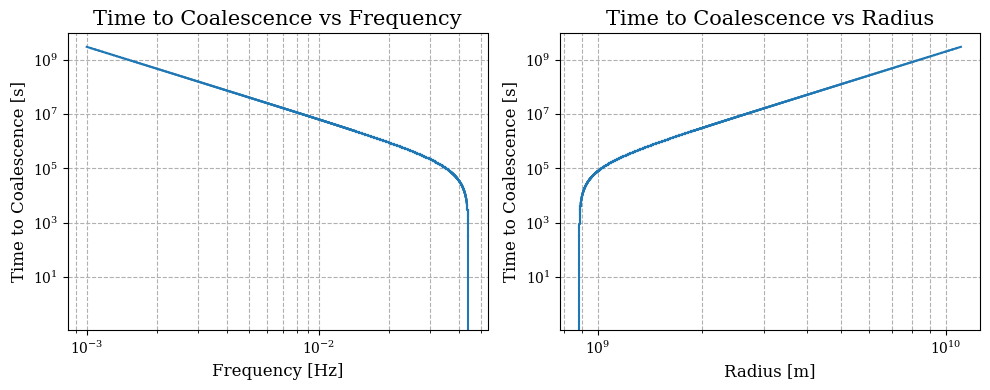

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Time to coalescence vs Frequency
ax1.loglog(freqs, pydd_time_to_coal)
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Time to Coalescence [s]')
ax1.set_title('Time to Coalescence vs Frequency', fontsize=15)
ax1.grid(True, which="both", ls="--")

# Plot 2: Time to coalescence vs Radius
ax2.loglog(radii, pydd_time_to_coal)
ax2.set_xlabel('Radius [m]')
ax2.set_ylabel('Time to Coalescence [s]')
ax2.set_title('Time to Coalescence vs Radius', fontsize=15)
ax2.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

## Compare the two analytical TTC

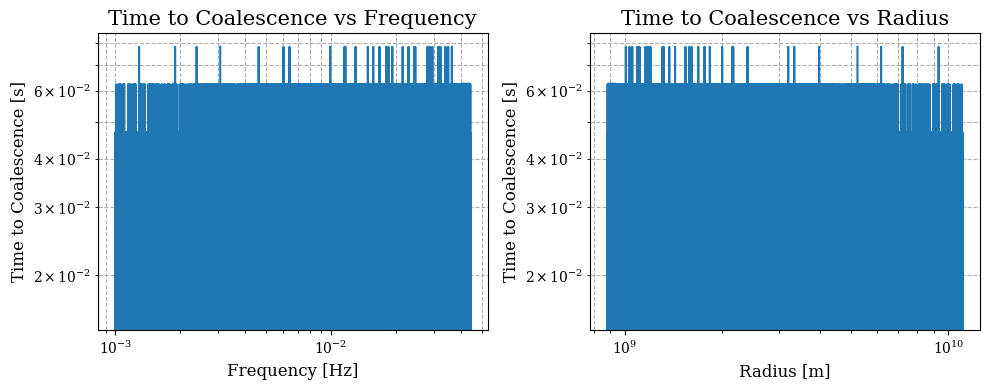

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Time to coalescence vs Frequency
ax1.loglog(freqs, np.abs(pydd_time_to_coal - my_time_to_coal_ANALYTICAL))
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Time to Coalescence [s]')
ax1.set_title('Time to Coalescence vs Frequency', fontsize=15)
ax1.grid(True, which="both", ls="--")

# Plot 2: Time to coalescence vs Radius
ax2.loglog(radii, np.abs(pydd_time_to_coal - my_time_to_coal_ANALYTICAL))
ax2.set_xlabel('Radius [m]')
ax2.set_ylabel('Time to Coalescence [s]')
ax2.set_title('Time to Coalescence vs Radius', fontsize=15)
ax2.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

In [107]:
# my version of coalescence **numerical**

my_time_to_coal_NUMERICAL = -time_to_coal_cumul(freqs[::-1], AD_mine)

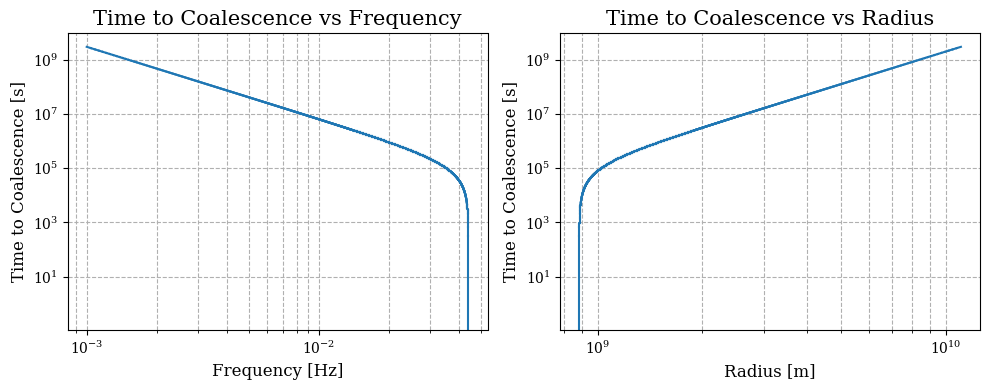

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Time to coalescence vs Frequency
ax1.loglog(freqs, my_time_to_coal_NUMERICAL[::-1])
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Time to Coalescence [s]')
ax1.set_title('Time to Coalescence vs Frequency', fontsize=15)
ax1.grid(True, which="both", ls="--")

# Plot 2: Time to coalescence vs Radius
ax2.loglog(radii, my_time_to_coal_NUMERICAL[::-1])
ax2.set_xlabel('Radius [m]')
ax2.set_ylabel('Time to Coalescence [s]')
ax2.set_title('Time to Coalescence vs Radius', fontsize=15)
ax2.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

## Compare numerical with analytical

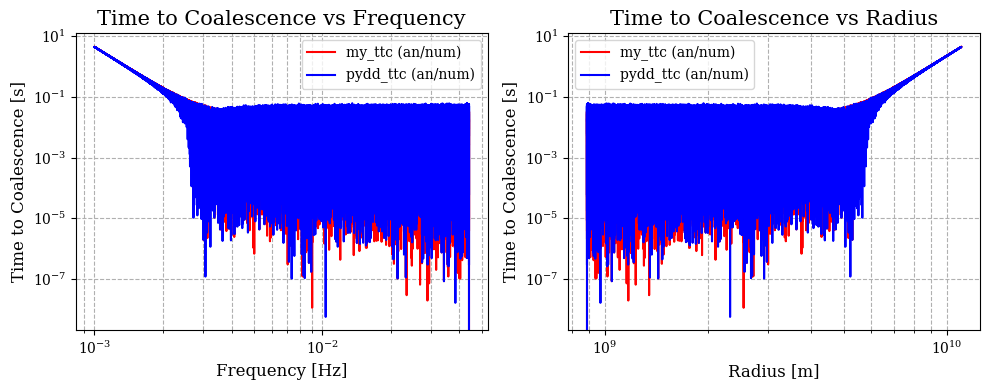

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Time to coalescence vs Frequency
ax1.loglog(freqs, np.abs(my_time_to_coal_NUMERICAL[::-1] - my_time_to_coal_ANALYTICAL), c='red', label='my_ttc (an/num)')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Time to Coalescence [s]')
ax1.set_title('Time to Coalescence vs Frequency', fontsize=15)
ax1.grid(True, which="both", ls="--")

ax1.loglog(freqs, np.abs(pydd_time_to_coal - my_time_to_coal_NUMERICAL[::-1]), c='blue', label='pydd_ttc (an/num)')

ax1.legend()

# Plot 2: Time to coalescence vs Radius ------------------------------------------
ax2.loglog(radii, np.abs(my_time_to_coal_NUMERICAL[::-1] - my_time_to_coal_ANALYTICAL), c='red', label='my_ttc (an/num)')
ax2.set_xlabel('Radius [m]')
ax2.set_ylabel('Time to Coalescence [s]')
ax2.set_title('Time to Coalescence vs Radius', fontsize=15)
ax2.grid(True, which="both", ls="--")

ax2.loglog(radii, np.abs(pydd_time_to_coal - my_time_to_coal_NUMERICAL[::-1]), c='blue', label='pydd_ttc (an/num)')

ax2.legend()

plt.tight_layout()
plt.show()

## Change the integration method

In [110]:
# my version of coalescence **numerical**

my_time_to_coal_NUMERICAL_new = -time_to_coal(freqs[::-1], AD_mine)

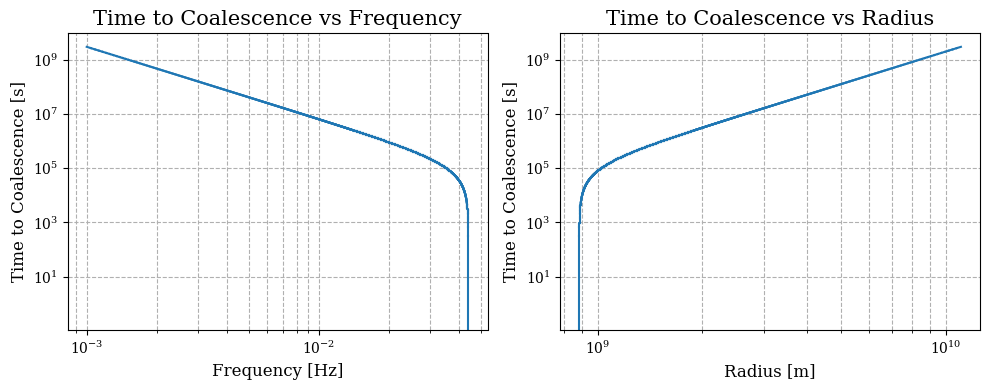

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Time to coalescence vs Frequency
ax1.loglog(freqs, my_time_to_coal_NUMERICAL_new[::-1])
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Time to Coalescence [s]')
ax1.set_title('Time to Coalescence vs Frequency', fontsize=15)
ax1.grid(True, which="both", ls="--")

# Plot 2: Time to coalescence vs Radius
ax2.loglog(radii, my_time_to_coal_NUMERICAL_new[::-1])
ax2.set_xlabel('Radius [m]')
ax2.set_ylabel('Time to Coalescence [s]')
ax2.set_title('Time to Coalescence vs Radius', fontsize=15)
ax2.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

## Compare the results

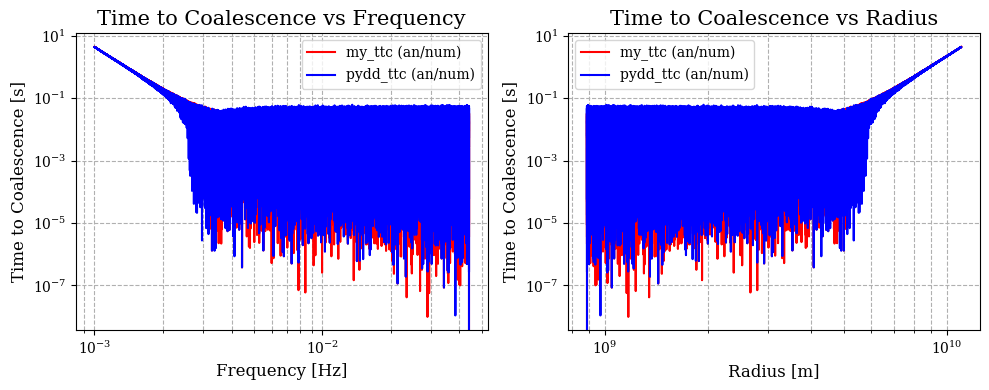

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Time to coalescence vs Frequency
ax1.loglog(freqs, np.abs(my_time_to_coal_NUMERICAL_new[::-1] - my_time_to_coal_ANALYTICAL), c='red', label='my_ttc (an/num)')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Time to Coalescence [s]')
ax1.set_title('Time to Coalescence vs Frequency', fontsize=15)
ax1.grid(True, which="both", ls="--")

ax1.loglog(freqs, np.abs(pydd_time_to_coal - my_time_to_coal_NUMERICAL_new[::-1]), c='blue', label='pydd_ttc (an/num)')

ax1.legend()

# Plot 2: Time to coalescence vs Radius ------------------------------------------
ax2.loglog(radii, np.abs(my_time_to_coal_NUMERICAL_new[::-1] - my_time_to_coal_ANALYTICAL), c='red', label='my_ttc (an/num)')
ax2.set_xlabel('Radius [m]')
ax2.set_ylabel('Time to Coalescence [s]')
ax2.set_title('Time to Coalescence vs Radius', fontsize=15)
ax2.grid(True, which="both", ls="--")

ax2.loglog(radii, np.abs(pydd_time_to_coal - my_time_to_coal_NUMERICAL_new[::-1]), c='blue', label='pydd_ttc (an/num)')

ax2.legend()

plt.tight_layout()
plt.show()

My theory is that we can either use the $r0 = \frac{6 G m_1}{c^2}$ (in paper but not in the code) or choose to use $r0 = \frac{6 G M_{\mathrm{tot}}}{c^2}$.

# Relative error

## Analytical

In [118]:
relative_error_PA = np.abs((my_time_to_coal_NUMERICAL_new[::-1] - my_time_to_coal_ANALYTICAL)/my_time_to_coal_ANALYTICAL)

/var/folders/x1/_4_0wf6n3vbb18gn1psjd98w0000gn/T/ipykernel_2187/335969975.py:1: RuntimeWarning: invalid value encountered in divide
  relative_error_PA = np.abs((my_time_to_coal_NUMERICAL_new[::-1] - my_time_to_coal_ANALYTICAL)/my_time_to_coal_ANALYTICAL)


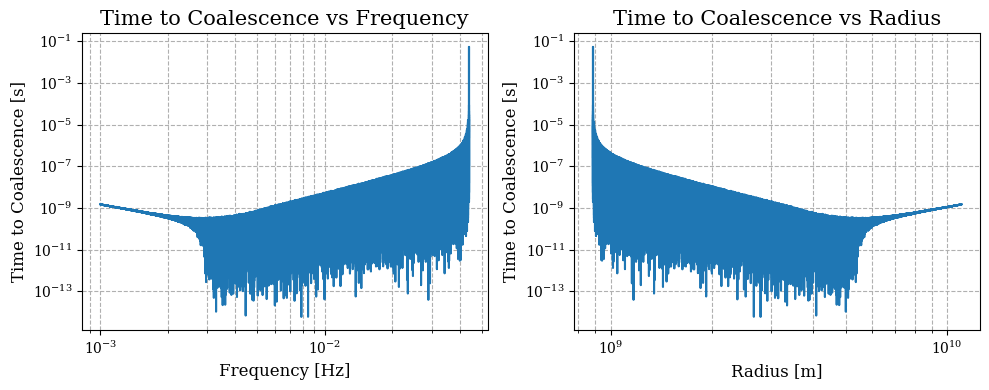

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Time to coalescence vs Frequency
ax1.loglog(freqs, relative_error_PA)
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Time to Coalescence [s]')
ax1.set_title('Time to Coalescence vs Frequency', fontsize=15)
ax1.grid(True, which="both", ls="--")

# Plot 2: Time to coalescence vs Radius
ax2.loglog(radii, relative_error_PA)
ax2.set_xlabel('Radius [m]')
ax2.set_ylabel('Time to Coalescence [s]')
ax2.set_title('Time to Coalescence vs Radius', fontsize=15)
ax2.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

## Numerical
## Trapezoids

In [116]:
relative_error_NA_1 = np.abs((my_time_to_coal_NUMERICAL[::-1] - my_time_to_coal_ANALYTICAL)/my_time_to_coal_ANALYTICAL)
relative_error_NP_1 = np.abs((pydd_time_to_coal - my_time_to_coal_NUMERICAL[::-1])/pydd_time_to_coal)

/var/folders/x1/_4_0wf6n3vbb18gn1psjd98w0000gn/T/ipykernel_2187/2418903562.py:1: RuntimeWarning: invalid value encountered in divide
  relative_error_NA_1 = np.abs((my_time_to_coal_NUMERICAL[::-1] - my_time_to_coal_ANALYTICAL)/my_time_to_coal_ANALYTICAL)
/var/folders/x1/_4_0wf6n3vbb18gn1psjd98w0000gn/T/ipykernel_2187/2418903562.py:2: RuntimeWarning: invalid value encountered in divide
  relative_error_NP_1 = np.abs((pydd_time_to_coal - my_time_to_coal_NUMERICAL[::-1])/pydd_time_to_coal)


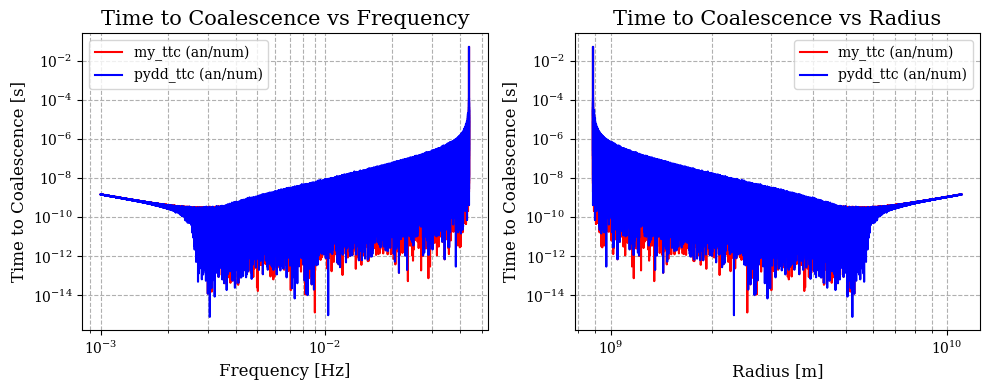

In [117]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Time to coalescence vs Frequency
ax1.loglog(freqs, relative_error_NA_1, c='red', label='my_ttc (an/num)')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Time to Coalescence [s]')
ax1.set_title('Time to Coalescence vs Frequency', fontsize=15)
ax1.grid(True, which="both", ls="--")

ax1.loglog(freqs, relative_error_NP_1, c='blue', label='pydd_ttc (an/num)')

ax1.legend()

# Plot 2: Time to coalescence vs Radius ------------------------------------------
ax2.loglog(radii, relative_error_NA_1, c='red', label='my_ttc (an/num)')
ax2.set_xlabel('Radius [m]')
ax2.set_ylabel('Time to Coalescence [s]')
ax2.set_title('Time to Coalescence vs Radius', fontsize=15)
ax2.grid(True, which="both", ls="--")

ax2.loglog(radii, relative_error_NP_1, c='blue', label='pydd_ttc (an/num)')

ax2.legend()

plt.tight_layout()
plt.show()

## ODE

In [114]:
relative_error_NA = np.abs((my_time_to_coal_NUMERICAL_new[::-1] - my_time_to_coal_ANALYTICAL)/my_time_to_coal_ANALYTICAL)
relative_error_NP = np.abs((pydd_time_to_coal - my_time_to_coal_NUMERICAL_new[::-1])/pydd_time_to_coal)

/var/folders/x1/_4_0wf6n3vbb18gn1psjd98w0000gn/T/ipykernel_2187/2645104727.py:1: RuntimeWarning: invalid value encountered in divide
  relative_error_NA = np.abs((my_time_to_coal_NUMERICAL_new[::-1] - my_time_to_coal_ANALYTICAL)/my_time_to_coal_ANALYTICAL)
/var/folders/x1/_4_0wf6n3vbb18gn1psjd98w0000gn/T/ipykernel_2187/2645104727.py:2: RuntimeWarning: invalid value encountered in divide
  relative_error_NP = np.abs((pydd_time_to_coal - my_time_to_coal_NUMERICAL_new[::-1])/pydd_time_to_coal)


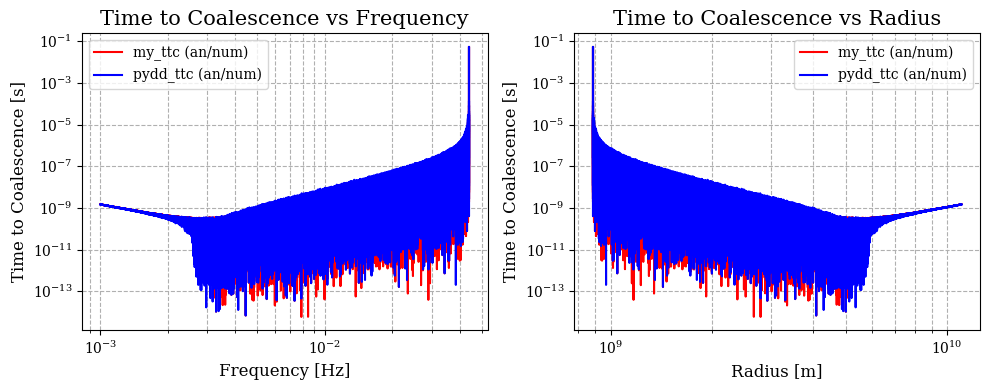

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Time to coalescence vs Frequency
ax1.loglog(freqs, relative_error_NA, c='red', label='my_ttc (an/num)')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Time to Coalescence [s]')
ax1.set_title('Time to Coalescence vs Frequency', fontsize=15)
ax1.grid(True, which="both", ls="--")

ax1.loglog(freqs, relative_error_NP, c='blue', label='pydd_ttc (an/num)')

ax1.legend()

# Plot 2: Time to coalescence vs Radius ------------------------------------------
ax2.loglog(radii, relative_error_NA, c='red', label='my_ttc (an/num)')
ax2.set_xlabel('Radius [m]')
ax2.set_ylabel('Time to Coalescence [s]')
ax2.set_title('Time to Coalescence vs Radius', fontsize=15)
ax2.grid(True, which="both", ls="--")

ax2.loglog(radii, relative_error_NP, c='blue', label='pydd_ttc (an/num)')

ax2.legend()

plt.tight_layout()
plt.show()

# Phase to coalescence:

The phase to coalescence for a given binary can be evaluated from the following formula:

$$\Phi_c = 2 \pi \int_{f}^{f_{\mathrm{isco}}} \frac{dt}{df} f df = 2 \pi \int_{f}^{f_{\mathrm{isco}}} \frac{dt}{dr} \frac{dr}{df} f df$$

In this notebook I will check the consistency between my version (numerical integration) and the one provided by pydd (analytical). 

In [174]:
# create vacuum env with my library m1, m2, dist, chirp_mass

VB_mine = myVacuumBinary(m1 = m1,
                         m2 = m2, 
                         dist = 1., # for now dist
                         chirp_mass = M_chirp
        )

# create vacuum env with pydd

VB_pydd = VacuumBinary(AD_pydd.PN,
        AD_pydd.M_chirp,
        AD_pydd.Phi_c,
        AD_pydd.tT_c,
        1., # for now dist
        AD_pydd.f_c,
    )

In [181]:
# my version of phase

my_phase_acc = phase_f(freqs[::-1], AD_mine)
my_phase_gw = phase_f(freqs[::-1], VB_mine)

In [184]:
# pydd version of phase 

phase_acc_pydd = Phi_to_c(freqs, AD_pydd)
phase_gw_pydd = Phi_to_c(freqs, VB_pydd)

## Compare numerical with analytical

In [189]:
relative_error_phase_acc = np.abs((my_phase_acc[::-1] + phase_acc_pydd) / phase_acc_pydd)
relative_error_phase_vac = np.abs((my_phase_gw[::-1] + phase_gw_pydd) / phase_gw_pydd)

/var/folders/x1/_4_0wf6n3vbb18gn1psjd98w0000gn/T/ipykernel_2187/1453512327.py:1: RuntimeWarning: invalid value encountered in divide
  relative_error_phase_acc = np.abs((my_phase_acc[::-1] + phase_acc_pydd) / phase_acc_pydd)
/var/folders/x1/_4_0wf6n3vbb18gn1psjd98w0000gn/T/ipykernel_2187/1453512327.py:2: RuntimeWarning: invalid value encountered in divide
  relative_error_phase_vac = np.abs((my_phase_gw[::-1] + phase_gw_pydd) / phase_gw_pydd)


- Accretion Disk

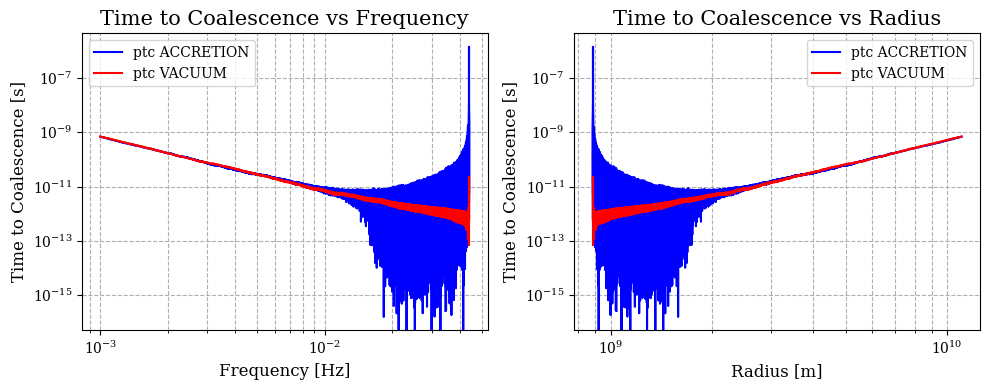

In [193]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Phase to coalescence vs Frequency
ax1.loglog(freqs, relative_error_phase_acc, c='blue', label='ptc ACCRETION')
ax1.loglog(freqs, relative_error_phase_vac, c='red', label='ptc VACUUM')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Time to Coalescence [s]')
ax1.set_title('Time to Coalescence vs Frequency', fontsize=15)
ax1.grid(True, which="both", ls="--")
ax1.legend()

# Plot 2: Phase to coalescence vs Radius ------------------------------------------
ax2.loglog(radii, relative_error_phase_acc, c='blue', label='ptc ACCRETION')
ax2.loglog(radii, relative_error_phase_vac, c='red', label='ptc VACUUM')
ax2.set_xlabel('Radius [m]')
ax2.set_ylabel('Time to Coalescence [s]')
ax2.set_title('Time to Coalescence vs Radius', fontsize=15)
ax2.grid(True, which="both", ls="--")
ax2.legend()

plt.tight_layout()
plt.show()